# US Institutions Financial Report

In [12]:
# May need to install libraries directly in Jupyter notebook with the following commands
#! pip3 install --user pandas
#! pip3 install --user psycopg
#! pip3 install --user matplotlib
import pandas as pd
import psycopg
from matplotlib import pyplot as plt
from credentials import DBNAME, HOST, USERNAME, PASSWORD

In [13]:
# Parameters
YEAR = 2022


In [14]:
# Set the connection and grab the data from SQL
YEAR = str(YEAR) + '-01-01 00:00:00'

# Connect to the database using parameters from credentials.py
conn = psycopg.connect(
    dbname=DBNAME,
    host=HOST,
    user=USERNAME,
    password=PASSWORD)

# Create a cursor and use it to submit/execute a query:
cur = conn.cursor()

select_cmd = """
    SELECT * FROM institutions 
    WHERE extracted_year = %s;
"""

all_select_cmd = """
    SELECT * FROM institutions 
    WHERE extracted_year <= %s;
"""

# Save to a dataframe
df = pd.DataFrame(cur.execute(select_cmd, (YEAR,)))
all_df = pd.DataFrame(cur.execute(all_select_cmd, (YEAR,)))
colnames =['pkey', 'opeid', 'name', 'address', 'latitude',
            'longitude', 'fips', 'region', 'ccbasic', 'cbsa', 
            'csa', 'accreditor', 'pred_degree', 'highest_degree',
            'control', 'admission_rate', 'in_state_tuit', 'out_state_tuit',
            'prog_year_tuit', 'revenue_tuit', 'two_yr_default',
            'three_yr_default', 'avg_faculty_salary', 'sat_avg', 
            'prop_loan', 'extracted_year', 'zip', 'city', 'state']
df.columns = colnames
all_df.columns = colnames

# Close the connection
cur.close()
conn.close()

# Data Summary

# Summary of Current College Tuition Rates

# Best and Worst Performing Institutions by Loan-Repayment Rates

We will sort our data by the three year default variable, which measures loan repayment rates. The best performing universities have the lowest default rates, and the worst have the highest rates.

In [17]:
# Sort the DataFrame by loan repayment rates in ascending order
df = df[df['name'].notna()]
df_sorted = df.sort_values(by='three_yr_default')

# Extract the top 10 institutions
best_performing = df_sorted.head(10)

# Filter out rows with None or NaN in 'name' and 'three_yr_default'
df_filtered = df.dropna(subset=['name', 'three_yr_default'])
df_filtered = df_filtered[df_filtered['name'] != 'None']

# Extract the bottom 10 institutions
worst_performing = df_filtered.sort_values(by='three_yr_default').tail(10)

best_performing_output = best_performing.loc[:, ['name', 'three_yr_default']]
worst_performing_output = worst_performing.loc[:, ['name', 'three_yr_default']]

print("Top 10 Best-Performing Institutions:")
print(best_performing_output)

print("\nBottom 10 Worst-Performing Institutions:")
print(worst_performing_output)

Empty DataFrame
Columns: [pkey, opeid, name, address, latitude, longitude, fips, region, ccbasic, cbsa, csa, accreditor, pred_degree, highest_degree, control, admission_rate, in_state_tuit, out_state_tuit, prog_year_tuit, revenue_tuit, two_yr_default, three_yr_default, avg_faculty_salary, sat_avg, prop_loan, extracted_year, zip, city, state]
Index: []

[0 rows x 29 columns]
Top 10 Best-Performing Institutions:
Empty DataFrame
Columns: [name, three_yr_default]
Index: []

Bottom 10 Worst-Performing Institutions:
Empty DataFrame
Columns: [name, three_yr_default]
Index: []


In [5]:
# Can export to a PDF if desired
# OPTIONAL: don't need to run
# best_performing[['name', 'three_yr_default']].to_csv('data/best_performing_institutions.csv', index=False)
# worst_performing[['name', 'three_yr_default']].to_csv('data/worst_performing_institutions.csv', index=False)

# Tuition and Loan Repayment Rates

How have tuition rates and loan repayment rates changed over time for the top 100 most expensive universities in the U.S.?
We will explore this by first finding the top 100 most expensive schools.

In [6]:
# First find the top 100 most expensive schools
# Find most expensive out of:
# (in_state_tuit + out_state_tuit)/2, or the average tuition cost

df['avg_tuition'] = (df['in_state_tuit'] + df['out_state_tuit']) / 2

df_sorted = df.sort_values(by='avg_tuition', ascending=False)

top_100 = df_sorted.head(100)

Next, graph these schools based on their tuition and loan repayment rates.

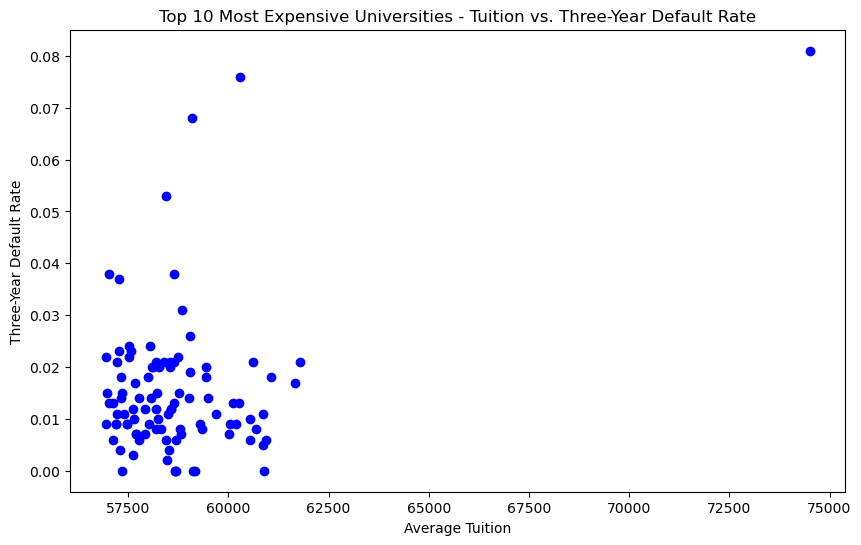

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(top_100['avg_tuition'], top_100['three_yr_default'], color='blue')
plt.title('Top 100 Most Expensive Universities - Tuition vs. Three-Year Default Rate')
plt.xlabel('Average Tuition')
plt.ylabel('Three-Year Default Rate')
plt.show()

# Relationship between average tuition and revenue tuition and SAT score

Are “smarter” colleges more expensive? Below, we have plots of the average tuition vs. SAT score as well as the revenue tuition vs. SAT score.

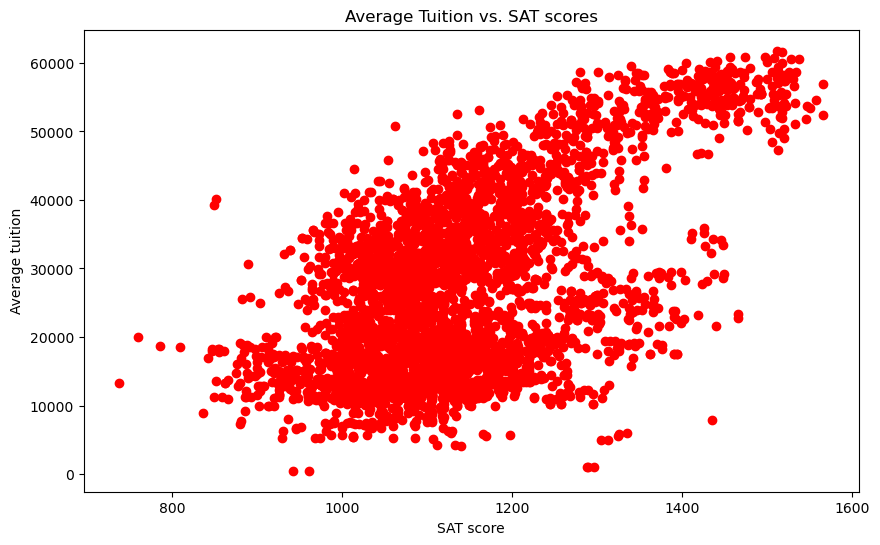

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df['sat_avg'], df['avg_tuition'], color='red')
plt.title('Average Tuition vs. SAT scores')
plt.xlabel('SAT score')
plt.ylabel('Average tuition')
plt.show()

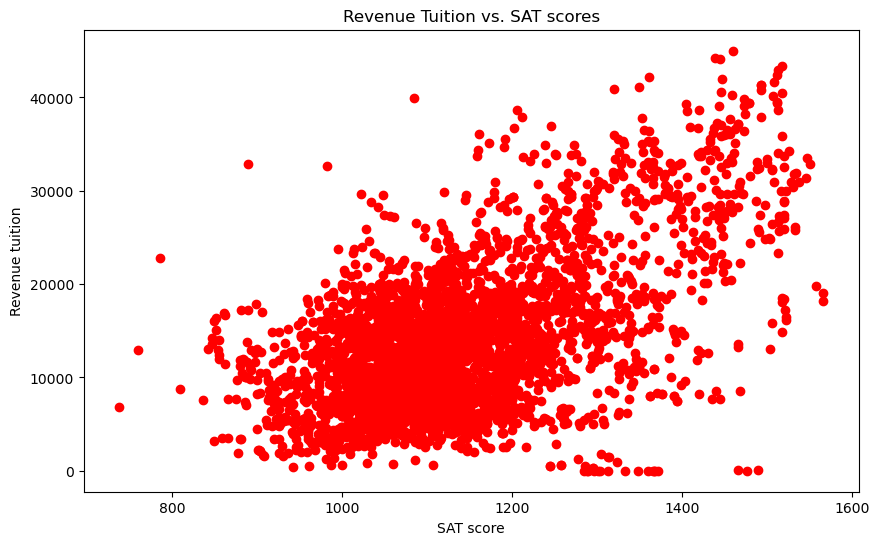

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(df['sat_avg'], df['revenue_tuit'], color='red')
plt.title('Revenue Tuition vs. SAT scores')
plt.xlabel('SAT score')
plt.ylabel('Revenue tuition')
plt.show()

# SAT Scores and College Admission Rate

# Faculty Salary and Revenue Tuition

In [10]:
average_rev_tuit_by_state = pd.DataFrame(df.groupby('state')['revenue_tuit'].mean())
df_sorted_rev = df.sort_values(by='revenue_tuit', ascending=False)
top_10 = df_sorted_rev.head(10)

In [11]:
average_salary_fac = df.copy()
average_salary_fac.groupby('state')
average_salary_fac.dropna()
df_sorted_fac = average_salary_fac.sort_values(by='avg_faculty_salary', ascending=False)
top_10 = df_sorted_fac.head(10)


In [12]:
#plt.figure(figsize=(10, 6))
#plt.hist(average_salary_fac['state'], bins=2)
#plt.title('Average Faculty by State')
#plt.xlabel('State')
#plt.ylabel('Average Monthly Faculty Salary')
#plt.show()

Relationship between average faculty salary and revenue tuition, which will show the relationship and contrast between how much students pay and how much faculties get paid. 

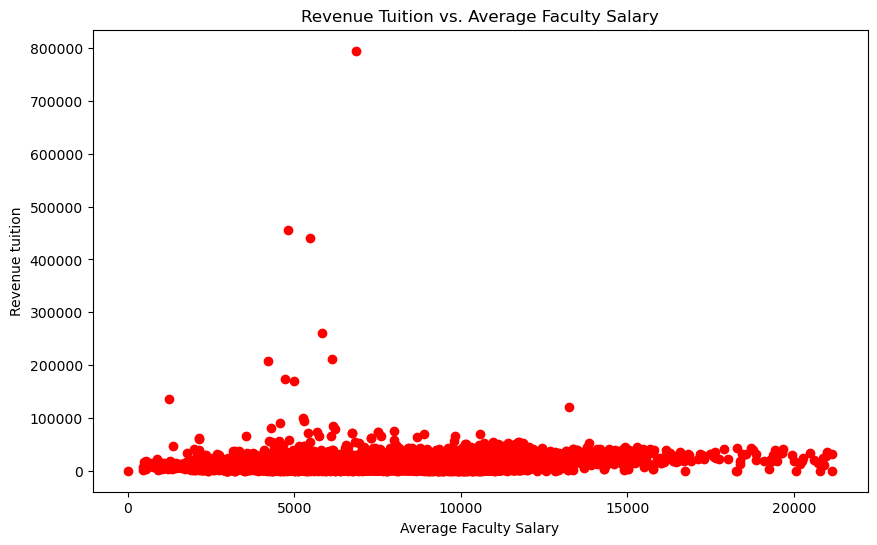

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(df['avg_faculty_salary'], df['revenue_tuit'], color='red')
plt.title('Revenue Tuition vs. Average Monthly Faculty Salary')
plt.xlabel('Average Faculty Salary')
plt.ylabel('Revenue tuition')
plt.show()

We seperate between public and private schools to see the difference between them. 

In [14]:
private_public = df.copy()
private_public.groupby('control')['avg_faculty_salary'].mean()

control
Private For-Profit    5116.111548
Private Non-Profit    7053.241339
Public                7682.234163
Name: avg_faculty_salary, dtype: float64

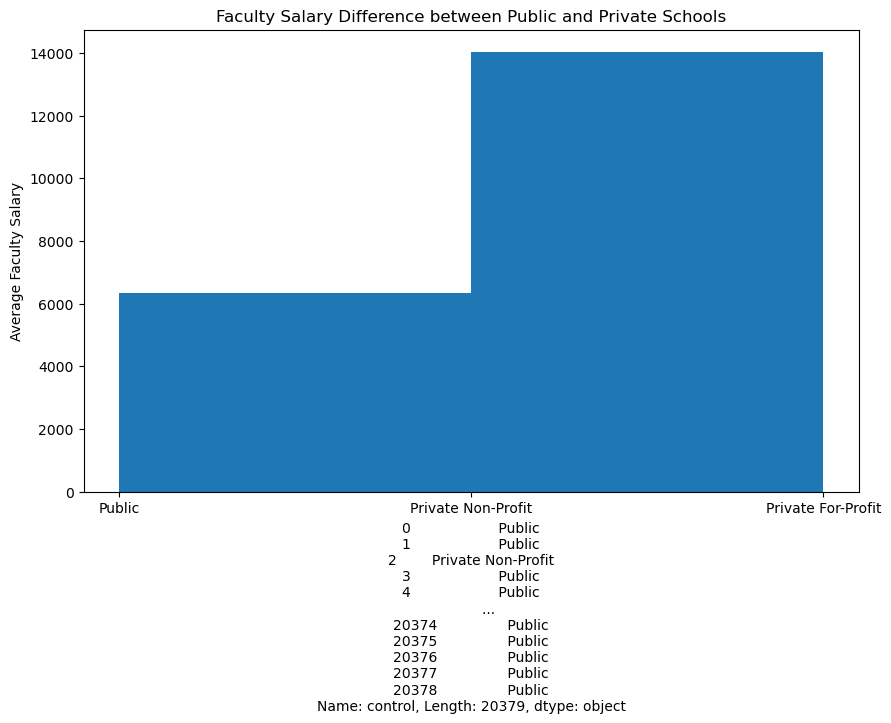

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(private_public['control'], bins=2)
plt.title('Faculty Salary Difference between Public and Private Schools')
plt.xlabel(private_public['control'])
plt.ylabel('Average Monthly Faculty Salary')
plt.show()